In [1]:
import numpy as np
import numpy.linalg as LA

# Collaborative Filtering

### Rating matrix
Function to get matrix N * M from input data, where N – number of users, M – number of items

In [2]:
def get_rating_matrix(data):
    users = data.copy()[:,0]
    items = data.copy()[:,1]
    ratings = data.copy()[:,2]

    user_count = np.unique(users)[-1]
    items_count = np.unique(items)[-1]

    # Subtracting 1 to get users and items indices beggining from 0
    users -= 1
    items -= 1
    
    # Getting matrix of ratings
    rat_matrix = np.zeros((user_count, items_count), dtype=int)

    for i in xrange(user_count):
        user_idxs = np.where(users == i)
        rat_matrix[i][items[user_idxs]] = ratings[user_idxs]
        
    return rat_matrix

### Similarity matrix
Function to get users or items similarity matrix
$$w_{ij} = \frac{\sum_{m \in M}{R_{im}R_{jm}}}{\sqrt{\sum_{m \in M}{R_{im} ^ 2}}\sqrt{\sum_{m \in M}{R_{jm} ^ 2}}}$$
where M – vector of rated elements in both row/column i and j

In [3]:
def get_similarity_matrix(rating_matrix, for_users=True):
    if for_users:
        # Getting number of rows (users)
        count = rating_matrix.shape[0]
    else:
        # Getting number of columns (items)
        count = rating_matrix.shape[1]
        
    similarity_matrix = np.ones((count, count)) * -1
    
    for i in xrange(count):
        # No need to iterate over items under diagonal
        for j in xrange(i + 1, count):
            if for_users:
                i_item = rating_matrix[i,:]
                j_item = rating_matrix[j,:]
            else:
                i_item = rating_matrix[:,i]
                j_item = rating_matrix[:,j]
                
            
            non_zero = np.where((i_item > 0) & (j_item > 0))[0]
            
            if non_zero.size == 0:
                similarity_matrix[i][j] = 0
                continue
                
            i_r = i_item[non_zero]
            j_r = j_item[non_zero]
            
            w_ij = np.dot(i_r.T, j_r) / (LA.norm(i_r) * LA.norm(j_r))
            
            similarity_matrix[i][j] = w_ij
    
    similarity_matrix[np.diag_indices(count)] = 1
    
    under_diag_idx = np.where(similarity_matrix == -1)
    above_diag_idx = (under_diag_idx[1], under_diag_idx[0])
    
    similarity_matrix[under_diag_idx] = similarity_matrix[above_diag_idx]
    
    return similarity_matrix

In [4]:
def predict_unknown(rating_matrix, similarity_matrix, k_users, indices_to_predict):
    user_count = rating_matrix.shape[0]
    new_rating_matrix = rating_matrix.copy()
    
    
    if similarity_matrix.shape[0] == user_count:
        user_user = True
    else:
        user_user = False
        
    
    for u, i in zip(indices_to_predict[0], indices_to_predict[1]):
        if user_user:
            not_null_users = np.where(rating_matrix[:,i] != 0)[0]

            if not_null_users.size == 0:
                continue

            # Getting indices of sorted by similarity not-null users
            not_null_sorted = np.argsort(similarity_matrix[u][not_null_users])[::-1]

            # Getting K nearest users
            nearest_users = not_null_users[not_null_sorted][:k_users]


            prediction = np.dot(similarity_matrix[u][nearest_users].T, 
                                rating_matrix[:,i][nearest_users]) / np.sum(similarity_matrix[u][nearest_users])

            if np.isnan(prediction):
                continue

            new_rating_matrix[u][i] = prediction
        else:
            not_null_items = np.where(rating_matrix[u,:] != 0)[0]
            
            
            if not_null_items.size == 0:
                continue
            
            not_null_sorted = np.argsort(similarity_matrix[i][not_null_items])[::-1]
            
            nearest_items = not_null_items[not_null_sorted][:k_users]
            
            prediction = np.dot(similarity_matrix[i][nearest_items].T, 
                    rating_matrix[u,:][nearest_items]) / np.sum(similarity_matrix[i][nearest_items])

            if np.isnan(prediction):
                continue

            new_rating_matrix[u][i] = prediction
            
    return new_rating_matrix

In [5]:
def get_mae(predicted, real, indices_to_predict):
    err = np.abs(predicted[indices_to_predict] - real[indices_to_predict])
    return err.sum() * 1.0 / err.shape[0]

## Task 1

In [6]:
# Loading data from files
train = np.loadtxt('data/ua.base', dtype=int)
test = np.loadtxt('data/ua.test', dtype=int)

indices_to_predict = (test[:,0] - 1, test[:,1] - 1)

## Task 2

In [7]:
rating_matrix = get_rating_matrix(train)
real_rating = get_rating_matrix(np.concatenate((train, test), axis=0))

In [8]:
similarity_matrix = get_similarity_matrix(rating_matrix)

## Task 3

In [9]:
user_maes = []
for k in xrange(1, 152, 5):
    new_rating = predict_unknown(rating_matrix, similarity_matrix, k, indices_to_predict)
    mae = get_mae(new_rating, real_rating, indices_to_predict)
    user_maes.append(mae)

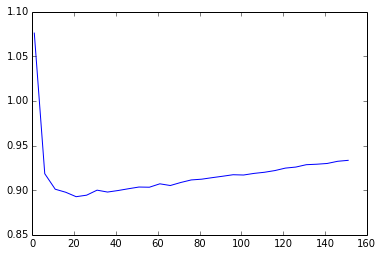

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, 152, 5), user_maes)

## Task 4

In [17]:
aver_rating_matrix = rating_matrix.copy().astype(float)

i = 0

for line in rating_matrix:
    known_marks = np.where(line != 0)
    aver = line[known_marks].mean()
    aver_rating_matrix[i][known_marks] -= aver
    i += 1
    
    
aver_real_rating = real_rating.copy().astype(float)
i = 0

for line in real_rating:
    known_marks = np.where(line != 0)
    aver = line[known_marks].mean()
    aver_real_rating[i][known_marks] -= aver
    i += 1    

In [18]:
user_maes_aver = []
for k in xrange(1, 152, 5):
    new_rating = predict_unknown(aver_rating_matrix, similarity_matrix, k, indices_to_predict)
    mae = get_mae(new_rating, aver_real_rating, indices_to_predict)
    user_maes_aver.append(mae)

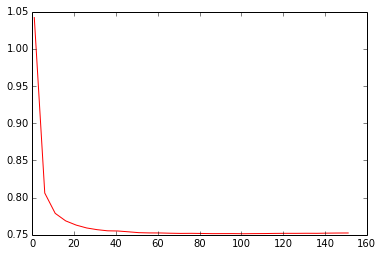

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, 152, 5), user_maes_aver, c='r')

Yes, after such subtracting results improved. Now each similarity value is Pearson correlation coefficient.
That give opportunity to find linear dependency between users behaviour, whereas usual approach doesn't.

## Task 5

In [24]:
items_similarity_matrix = get_similarity_matrix(rating_matrix, for_users=False)

In [25]:
items_maes = []
for k in xrange(1, 152, 5):
    new_rating = predict_unknown(rating_matrix, items_similarity_matrix, k, indices_to_predict)
    mae = get_mae(new_rating, real_rating, indices_to_predict)
    items_maes.append(mae)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in double_scalars


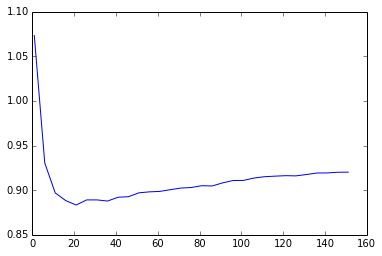

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, 152, 5), items_maes)

In [27]:
aver_rating_matrix = rating_matrix.copy().astype(float)

i = 0

for line in rating_matrix:
    known_marks = np.where(line != 0)
    aver = line[known_marks].mean()
    aver_rating_matrix[i][known_marks] -= aver
    i += 1
    
    
aver_real_rating = real_rating.copy().astype(float)
i = 0

for line in real_rating:
    known_marks = np.where(line != 0)
    aver = line[known_marks].mean()
    aver_real_rating[i][known_marks] -= aver
    i += 1    

In [28]:
maes = []
for k in xrange(1, 152, 5):
    new_rating = predict_unknown(aver_rating_matrix, items_similarity_matrix, k, indices_to_predict)
    mae = get_mae(new_rating, aver_real_rating, indices_to_predict)
    maes.append(mae)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in double_scalars


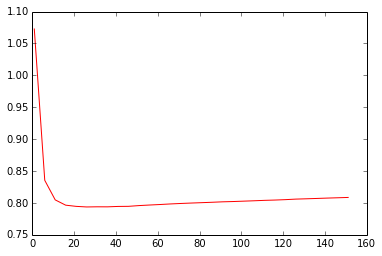

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, 152, 5), maes, c='r')

So, in item-item filtering using as similarity Pearson correlation made result worse, than in user-user. 
Let see visualization of both similarity matrices.

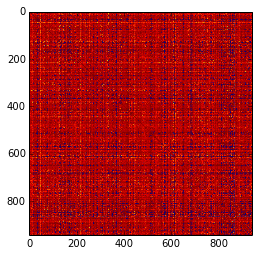

In [30]:
plt.imshow(similarity_matrix)

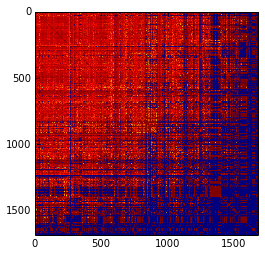

In [31]:
plt.imshow(items_similarity_matrix)

So, in item-item matrix items seems to have more zero similarities, than in user-user. 
That is caused because number of items rather bigger than number of users

It is true that number of K is approximately the same for all considered algorithms. 
Using K [20, 40] would be optimal for best quality and perfomance.